In [91]:
import numpy as np
import nibabel
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import statistics
from PIL import Image
import skimage
import logging
logging.basicConfig(level=logging.INFO, force=True)

In [296]:
volume = './volume-100.nii.gz'
mask = './segmentation-100.nii.gz'
masks = './masks_png'
images = './images_png'

!mkdir masks_tumor_png images_tumor_png

mkdir: cannot create directory ‘masks_tumor_png’: File exists
mkdir: cannot create directory ‘images_tumor_png’: File exists


In [45]:
def nii_liver_to_png(nii_file, png_root):
    base = os.path.basename(nii_file).replace('.nii.gz', '')
    
    folder_name = os.path.join(png_root.replace('.nii.gz', ''), base)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
        
    os.mkdir(folder_name)
    
    nii_img = nibabel.load(nii_file).get_fdata()
    depth = nii_img.shape[2]
    for d in range(0, depth):
        png_file_name = os.path.join(folder_name, f"{d}.png")
        
        windowed_slice = skimage.exposure.rescale_intensity(
            np.clip(nii_img[:, :, d], -45, 105), # -45, 105
            in_range='image', out_range=(0, 255)
        )
        
        png_file_data = skimage.transform.resize(windowed_slice, (256, 256), anti_aliasing=True)
        skimage.io.imsave(png_file_name, np.uint8(png_file_data))

In [46]:
nii_to_png(volume, './images_png3')

In [ ]:
!mkdir masks_png


In [57]:
def nii_mask_to_png(nii_file, png_root):
    base = os.path.basename(nii_file).replace('.nii.gz', '')
    
    folder_name = os.path.join(png_root.replace('.nii.gz', ''), base)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
        
    os.mkdir(folder_name)
    
    nii_img = nibabel.load(nii_file).get_fdata()
    depth = nii_img.shape[2]
    for d in range(400, depth):
        png_file_name = os.path.join(folder_name, f"{d}.png")
        
        windowed_slice = skimage.exposure.rescale_intensity(
            nii_img[:, :, d], in_range='image', out_range=(0, 255)
        )

        png_file_data = skimage.transform.resize(windowed_slice, (256, 256), anti_aliasing=True)
        skimage.io.imsave(png_file_name, np.uint8(png_file_data), check_contrast=False)

In [58]:
d = nii_mask_to_png(mask, './masks_png/')

In [60]:
np.unique(np.uint8(d))

array([  0,   6,  12,  13,  19,  69,  70,  75,  76, 120, 121, 127, 133,
       177, 178, 179, 184, 185, 235, 241, 242, 248, 254, 255], dtype=uint8)

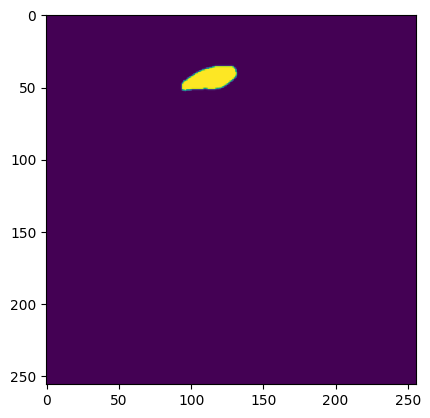

In [61]:
plt.imshow(d)

## For tumors
1. Only train masked liver images
2. Exclude null images
3. Use tumor masks

In [45]:
ZEROS = np.zeros((512, 512), dtype=np.uint8)

def nii_liver_to_png(liver, mask, png_root):
    base = os.path.basename(liver).replace('.nii.gz', '')
    
    folder_name = os.path.join(png_root.replace('.nii.gz', ''), base)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
        
    os.mkdir(folder_name)
    
    liver_img = nibabel.load(liver).get_fdata()
    mask_img = nibabel.load(mask).get_fdata()

    liver_img = np.clip(liver_img, -45, 105)
    mask_img = np.clip(mask_img, 0, 1)
    
    depth = liver_img.shape[2]
    for d in range(0, depth):
        png_file_name = os.path.join(folder_name, f"{d}.png")
        
        windowed_slice = np.uint8(skimage.exposure.rescale_intensity(
            liver_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        windowed_mask = np.uint8(skimage.exposure.rescale_intensity(
            mask_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        final_img = np.uint8(windowed_slice & windowed_mask)
        if np.all(final_img == ZEROS):
            continue

        skimage.io.imsave(png_file_name, final_img, check_contrast=False)

In [46]:
!mkdir ./images2_tumor_png
nii_liver_to_png(volume, mask, './images2_tumor_png')

mkdir: cannot create directory ‘./images2_tumor_png’: File exists


In [298]:
ZEROS = np.zeros((512, 512))

def nii_tumor_mask_to_png(liver, mask, png_root):
    base = os.path.basename(mask).replace('.nii.gz', '')
    
    folder_name = os.path.join(png_root.replace('.nii.gz', ''), base)
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)
        
    os.mkdir(folder_name)
    
    liver_img = nibabel.load(liver).get_fdata()
    mask_img = nibabel.load(mask).get_fdata()

    liver_img = np.clip(liver_img, -45, 105)
    tumor_img = np.clip(mask_img, 1, 2)
    mask_img = np.clip(mask_img, 0, 1)
    
    depth = liver_img.shape[2]
    for d in range(0, depth):
        png_file_name = os.path.join(folder_name, f"{d}.png")
        
        windowed_slice = np.uint8(skimage.exposure.rescale_intensity(
            liver_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        windowed_mask = np.uint8(skimage.exposure.rescale_intensity(
            mask_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        tumor_mask = np.uint8(skimage.exposure.rescale_intensity(
            tumor_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        final_img = np.uint8(windowed_slice & windowed_mask)
        if np.all(final_img == ZEROS):
            continue

        skimage.io.imsave(png_file_name, tumor_mask, check_contrast=False)

In [299]:
nii_tumor_mask_to_png(volume, mask, './masks_tumor_png/')

In [ ]:
def liver_and_tumor_png(liver, mask, liver_root, mask_root):
    liver_base = os.path.basename(liver).replace('.nii.gz', '')
    mask_base  = os.path.basename(mask).replace('.nii.gz', '')

    liver_folder_name = os.path.join(liver_root.replace('.nii.gz', ''), liver_base)
    if os.path.exists(liver_folder_name):
        shutil.rmtree(liver_folder_name)
    os.mkdir(liver_folder_name)
    
    mask_folder_name = os.path.join(mask_root.replace('.nii.gz', ''), mask_base)
    if os.path.exists(mask_folder_name):
        shutil.rmtree(mask_folder_name)
    os.mkdir(mask_folder_name)

    liver_img = nibabel.load(liver).get_fdata()
    mask_img2 = nibabel.load(mask).get_fdata()

    liver_img = np.clip(liver_img, -45, 105)
    mask_img = np.clip(mask_img2, 0, 1)
    tumor_img = np.clip(mask_img2, 1, 2) - 1
    assert tumor_img.min() == 0 and tumor_img.max() == 1
    
    for d in range(0, liver_img.shape[2]):
        liver_png_file_name = os.path.join(liver_folder_name, f"{d}.png")
        tumor_png_file_name = os.path.join(mask_folder_name, f"{d}.png")
        
        windowed_slice = np.uint8(skimage.exposure.rescale_intensity(
            liver_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        windowed_mask = np.uint8(skimage.exposure.rescale_intensity(
            mask_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        tumor_mask = np.uint8(skimage.exposure.rescale_intensity(
            tumor_img[:, :, d], in_range='image', out_range=(0, 255)
        ))

        final_img = np.uint8(windowed_slice & windowed_mask)
        if np.all(final_img == ZEROS):
            continue

        skimage.io.imsave(liver_png_file_name, final_img, check_contrast=False)
        skimage.io.imsave(tumor_png_file_name, tumor_mask, check_contrast=False)

In [ ]:
liver_and_tumor_png(volume, mask, './images2_tumor_png/', './masks_tumor_png/')

In [350]:
def segment_tumor(Ipath, dst_path):
    I = skimage.io.imread(Ipath)
    print(np.unique(I))
    
    a, b = skimage.filters.threshold_multiotsu(I)
    T = ((a <= I) & (I <= b))
    T0 = skimage.morphology.area_closing(T, area_threshold=128)
    T2 = skimage.morphology.remove_small_objects(T0, connectivity=8, min_size=128)
    T2 = np.uint8(skimage.exposure.rescale_intensity(T2, in_range='image', out_range=(0, 255)))
    return skimage.io.imsave(dst_path, T2, check_contrast=False)

In [ ]:
!mkdir prediction_masks prediction_masks/volume-100
for path in glob('./images2_tumor_png/volume-100/*.png'):
    dst_path = path.replace('images2_tumor_png', 'prediction_masks/')
    segment_tumor(path, dst_path)

In [343]:
def calculate_dice_coefficient(ground_truth_path, predicted_path):
    true_mask = skimage.io.imread(ground_truth_path) / 255
    pred_mask = skimage.io.imread(predicted_path) / 255

    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask)
    dice_coefficient = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice_coefficient

0.808241388791659

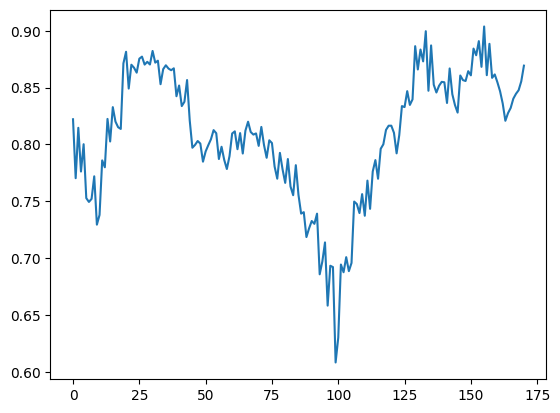

In [344]:
scores = []

prediction = sorted(glob('./prediction_masks/volume-100/*.png'))
ground = sorted(glob('./masks_tumor_png/segmentation-100/*.png'))

for p, g in zip(prediction[50:], ground[50:]):
    scores.append(calculate_dice_coefficient(g, p))

plt.plot(scores)
statistics.mean(scores)